In [112]:
import numpy as np
import pandas as pd
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, OneHotEncoder, OrdinalEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [113]:
datos = ('LOD.csv')
df = pd.read_csv(datos)

C:\Users\alexl\AppData\Local\Temp/ipykernel_19384/871816070.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(datos)


In [114]:
df = pd.DataFrame(df)

In [115]:
percentil_95 = df['surgery_length_of_duration'].quantile(0.95)


# Filtrar valores mayores que el percentil 0.9
df = df[(df['surgery_length_of_duration'] <= percentil_95)  & (df['surgery_length_of_duration'] >= 0)]

In [116]:
df['surgery_length_of_duration'].isna().sum()

0

In [117]:
percentil_95 = df['age'].quantile(0.95)

# Filtrar valores mayores que el percentil 0.9. Eliminadas 5400 filas
df = df[df['age'] < percentil_95]

In [118]:
percentil_995 = df['weight'].quantile(0.99)
print(percentil_995)

# Filtrar valores mayores que el percentil 0.9. Eliminadas 0, peso maximo 
df = df[(df['weight'] >= 140) | (df['age'] >= 12)]

148.0


In [119]:
df['character_of_intervention'].unique()

array(['HOSP', 'AMB'], dtype=object)

In [120]:
dummies = pd.get_dummies(df['character_of_intervention'], prefix='character_of_intervention', dtype=int)

# Renombrar las columnas según tus especificaciones
dummies.rename(columns={'character_of_intervention_AMB': 'AMB', 'character_of_intervention_HOSP': 'HOSP'}, inplace=True)

# Concatenar las columnas dummy con el DataFrame original
df = pd.concat([df, dummies], axis=1)

# Eliminar la columna original 'character_of_intervention'
df.drop(columns=['character_of_intervention'], inplace=True)

In [121]:
print(df['AMB'].isnull().sum())
print(df['HOSP'].isnull().sum())

0
0


In [122]:
df['gender'].value_counts()

gender
female    60679
male      51263
Name: count, dtype: int64

In [123]:
most_frequent_gender = df['gender'].mode()[0]
df['gender'].fillna(most_frequent_gender, inplace=True)

# Crear nuevas columnas 'female' y 'male' y asignar valores
df['female'] = (df['gender'] == 'female').astype(int)
df['male'] = (df['gender'] == 'male').astype(int)

df.drop(columns=['gender'], inplace=True)

In [124]:
df['female'].isnull().sum()

0

In [125]:
df['health_service'] = df['health_service'].str.split().str[-1]

In [126]:
df['health_service'].unique()

array(['2', '3', '4', '5', '6', '7', '8', '10', '11', '13', '14', '15',
       '16', '17', '1', '0', '19', '18', '20', '21', '9', '22', '23',
       '25', '12', '24', '26', '28', '29', '30', '31', '32', '33', '34',
       '36', '27', '37', '38', '35', '39', '40', '41', '42', '44', '45',
       '47', '48', '49', '50', '51', '53', '54', '55', '56', '57', '58',
       '52'], dtype=object)

In [127]:
df.columns

Index(['main_procedure', 'main_condition', 'secondary_procedure',
       'health_service', 'asa_score', 'age', 'weight', 'height', 'comorbidity',
       'anesthesia_local', 'anesthesia_sedation', 'anesthesia_plexus_block',
       'anesthesia_intradural', 'anesthesia_epidural', 'anesthesia_general',
       'surgery_length_of_duration', 'cleaning_time', 'recovery_time', 'AMB',
       'HOSP', 'female', 'male'],
      dtype='object')

In [128]:
df['comorbidity']=df['comorbidity'].fillna(0)

In [129]:
for indice, valor in df['comorbidity'].items():
    if valor in ('lung_disease', 'cancer', 'heart_disease', 'hypertension',
       'kidney_disease', 'obesity','diabetes', 'drug_abuse',
       'liver_disease', 'alcoholism', 'hiv', 'smoker'):
        df.loc[indice, 'comorbidity'] = 1

In [130]:
df['comorbidity'].unique()

array([1, 0], dtype=object)

In [131]:
# Calcula las proporciones de cada valor en 'asa_score'
proporciones = df['asa_score'].value_counts(normalize=True)

# Rellena los valores faltantes en 'asa_score' con valores muestreados de acuerdo con las proporciones
valores_imputados = proporciones.sample(
    n=df['asa_score'].isnull().sum(),
    replace=True,
    weights=proporciones.values
).index

# Rellena los valores faltantes en 'asa_score' con los valores imputados
df.loc[df['asa_score'].isnull(), 'asa_score'] = valores_imputados


# Verifica que ya no haya valores faltantes en 'asa_score'
print(df['asa_score'].isnull().sum())


0


In [132]:
df['asa_score'].value_counts()


asa_score
2.0    57406
3.0    27631
1.0    25026
4.0     1826
5.0       54
Name: count, dtype: int64

In [133]:
df.columns

Index(['main_procedure', 'main_condition', 'secondary_procedure',
       'health_service', 'asa_score', 'age', 'weight', 'height', 'comorbidity',
       'anesthesia_local', 'anesthesia_sedation', 'anesthesia_plexus_block',
       'anesthesia_intradural', 'anesthesia_epidural', 'anesthesia_general',
       'surgery_length_of_duration', 'cleaning_time', 'recovery_time', 'AMB',
       'HOSP', 'female', 'male'],
      dtype='object')

In [134]:
#Vacios rellena con -1
df['main_procedure'] = df['main_procedure'].fillna(-1)
#Pasa main procedure a string y si contiene letras no sirve y rellena con -1. Despues pasa a float
df['main_procedure'] = df['main_procedure'].astype(str)
df['main_procedure'] = df['main_procedure'].where(~df['main_procedure'].str.contains('[a-zA-Z]'), -1)
df['main_procedure'] = df['main_procedure'].astype(float)

#df['main_procedure'].unique()

In [135]:
def asignar_etiqueta(valor):

    diccionario_rangos = {
        (-1.01, 0.01):  'Undefined',
        (0.01, 0.96): 'Not elsewhere classified',
        (0.99, 5.9): 'Nervous System',
        (5.9, 7.99):'Endocrine System',
        (7.99, 16.99): 'Eye',
        (16.99, 17.81): 'Other MD and TP',
        (17.99, 20.99): 'Ear',
        (20.99, 29.99): 'Nose, Mouth and Pharynx',
        (29.99, 34.99): 'Respiratory System',
        (34.99, 39.99): 'Cardiovascular System',
        (39.99, 41.99): 'Hemic and Lymphatic System',
        (41.99, 54.99): 'Digestive System',
        (54.99, 59.99): 'Urinary System',
        (59.99, 64.99): 'Male Genital Organs',
        (64.99, 71.99): 'Female Genital Organs',
        (71.99, 75.99): 'Obstetrical Procedures',
        (75.99, 84.99): 'Muscoloskeletal System',
        (84.99, 86.99): 'Integumentary System',
        (86.99, 99.99): 'Miscellaneous Diagnostic'
    }
    for rango, etiqueta in diccionario_rangos.items():
        if rango[0] <= valor < rango[1]:
            return etiqueta
    return None


# Aplica la función para asignar etiquetas a la columna main_condition
df['etiqueta'] = df['main_procedure'].apply(asignar_etiqueta)

# Crea las columnas adicionales y asigna 1 o 0 según corresponda
for etiqueta in df['etiqueta'].unique():
    if etiqueta is not None:
        df[etiqueta] = df['etiqueta'].apply(lambda x: 1 if x == etiqueta else 0)

# Elimina la columna original 'main_condition' y la columna auxiliar 'etiqueta'
df.drop(columns=['main_procedure', 'etiqueta'], inplace=True)

# Reordena las columnas para mover las nuevas columnas a la segunda posición


In [136]:
df.columns

Index(['main_condition', 'secondary_procedure', 'health_service', 'asa_score',
       'age', 'weight', 'height', 'comorbidity', 'anesthesia_local',
       'anesthesia_sedation', 'anesthesia_plexus_block',
       'anesthesia_intradural', 'anesthesia_epidural', 'anesthesia_general',
       'surgery_length_of_duration', 'cleaning_time', 'recovery_time', 'AMB',
       'HOSP', 'female', 'male', 'Respiratory System', 'Eye',
       'Female Genital Organs', 'Other MD and TP', 'Digestive System',
       'Undefined', 'Urinary System', 'Muscoloskeletal System',
       'Hemic and Lymphatic System', 'Integumentary System',
       'Male Genital Organs', 'Nose, Mouth and Pharynx',
       'Cardiovascular System', 'Nervous System', 'Ear',
       'Not elsewhere classified', 'Obstetrical Procedures',
       'Endocrine System', 'Miscellaneous Diagnostic'],
      dtype='object')

In [137]:

df['main_condition'] = df['main_condition'].fillna(-1)
#Pasa a string, cambia . por espacio y desp elimina .. Si contiene letras -1. Desp a float.
df['main_condition'] = df['main_condition'].astype(str)
df['main_condition'] = df['main_condition'].str.replace(' ', '.')
df['main_condition'] = df['main_condition'].str.rstrip('.')
df['main_condition'] = df['main_condition'].where(~df['main_condition'].str.contains('[a-zA-Z]'), -1)
df['main_condition'] = df['main_condition'].astype(float)

In [138]:
def asignar_etiqueta(valor):
    diccionario_rangos = {
        (0.01, 139.8): 'INFECTIOUS AND PARASITIC DISEASES (001-139)',
        (140.0, 239.9): 'NEOPLASMS (140-239)',
        (240.0, 279.9): 'ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS (240-279)',
        (280.0, 289.9): 'DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS (280-289)',
        (290.0, 319.0): 'MENTAL, BEHAVIORAL AND NEURODEVELOPMENTAL DISORDERS (290-319)',
        (320.0, 389.9): 'DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS (320-389)',
        (390.0, 459.9): 'DISEASES OF THE CIRCULATORY SYSTEM (390-459)',
        (460.0, 519.9): 'DISEASES OF THE RESPIRATORY SYSTEM (460-519)',
        (520.0, 579.9): 'DISEASES OF THE DIGESTIVE SYSTEM (520-579)',
        (580.0, 629.9): 'DISEASES OF THE GENITOURINARY SYSTEM (580-629)',
        (630.0, 679.14): 'COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM (630-679)',
        (680.0, 709.9): 'DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE (680-709)',
        (710.0, 739.9): 'DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE (710-739)',
        (740.0, 759.9): 'CONGENITAL ANOMALIES (740-759)',
        (760.0, 779.9): 'CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD (760-779)',
        (780.01, 799.9): 'SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS (780-799)',
        (800.0, 999.9): 'INJURY AND POISONING (800-999)',
        (-5.0, 0.0): 'Undefined',
    }
    for rango, etiqueta in diccionario_rangos.items():
        if rango[0] <= valor <= rango[1]:
            return etiqueta
    return None

# Aplica la función para asignar etiquetas a la columna main_condition
df['etiqueta'] = df['main_condition'].apply(asignar_etiqueta)

# Crea las columnas adicionales y asigna 1 o 0 según corresponda
for etiqueta in df['etiqueta'].unique():
    if etiqueta is not None:
        df[etiqueta] = df['etiqueta'].apply(lambda x: 1 if x == etiqueta else 0)

# Elimina la columna original 'main_condition' y la columna auxiliar 'etiqueta'
df.drop(columns=['main_condition', 'etiqueta'], inplace=True)

# Reordena las columnas para mover las nuevas columnas a la segunda posición


In [139]:
df.columns

Index(['secondary_procedure', 'health_service', 'asa_score', 'age', 'weight',
       'height', 'comorbidity', 'anesthesia_local', 'anesthesia_sedation',
       'anesthesia_plexus_block', 'anesthesia_intradural',
       'anesthesia_epidural', 'anesthesia_general',
       'surgery_length_of_duration', 'cleaning_time', 'recovery_time', 'AMB',
       'HOSP', 'female', 'male', 'Respiratory System', 'Eye',
       'Female Genital Organs', 'Other MD and TP', 'Digestive System',
       'Undefined', 'Urinary System', 'Muscoloskeletal System',
       'Hemic and Lymphatic System', 'Integumentary System',
       'Male Genital Organs', 'Nose, Mouth and Pharynx',
       'Cardiovascular System', 'Nervous System', 'Ear',
       'Not elsewhere classified', 'Obstetrical Procedures',
       'Endocrine System', 'Miscellaneous Diagnostic', 'NEOPLASMS (140-239)',
       'DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS (320-389)',
       'DISEASES OF THE DIGESTIVE SYSTEM (520-579)',
       'DISEASES OF THE MU

In [140]:
df['health_service'] = df['health_service'].astype(int)
df['comorbidity'] = df['comorbidity'].astype(int)

In [141]:
x = df[['secondary_procedure', 'health_service', 'asa_score', 'age', 'weight',
       'height', 'comorbidity', 'anesthesia_local', 'anesthesia_sedation',
       'anesthesia_plexus_block', 'anesthesia_intradural',
       'anesthesia_epidural', 'anesthesia_general', 'cleaning_time', 'recovery_time',
       'HOSP', 'male', 'Respiratory System', 'Eye',
       'Female Genital Organs', 'Other MD and TP', 'Digestive System',
       'Undefined', 'Urinary System', 'Muscoloskeletal System',
       'Hemic and Lymphatic System', 'Integumentary System',
       'Male Genital Organs', 'Nose, Mouth and Pharynx',
       'Cardiovascular System', 'Nervous System', 'Ear',
       'Not elsewhere classified', 'Obstetrical Procedures',
       'Endocrine System', 'Miscellaneous Diagnostic', 'NEOPLASMS (140-239)',
       'DISEASES OF THE NERVOUS SYSTEM AND SENSE ORGANS (320-389)',
       'DISEASES OF THE DIGESTIVE SYSTEM (520-579)',
       'DISEASES OF THE MUSCULOSKELETAL SYSTEM AND CONNECTIVE TISSUE (710-739)',
       'INFECTIOUS AND PARASITIC DISEASES (001-139)',
       'DISEASES OF THE GENITOURINARY SYSTEM (580-629)',
       'INJURY AND POISONING (800-999)',
       'DISEASES OF THE RESPIRATORY SYSTEM (460-519)',
       'SYMPTOMS, SIGNS, AND ILL-DEFINED CONDITIONS (780-799)',
       'DISEASES OF THE SKIN AND SUBCUTANEOUS TISSUE (680-709)',
       'DISEASES OF THE CIRCULATORY SYSTEM (390-459)',
       'ENDOCRINE, NUTRITIONAL AND METABOLIC DISEASES, AND IMMUNITY DISORDERS (240-279)',
       'COMPLICATIONS OF PREGNANCY, CHILDBIRTH, AND THE PUERPERIUM (630-679)',
       'CONGENITAL ANOMALIES (740-759)',
       'MENTAL, BEHAVIORAL AND NEURODEVELOPMENTAL DISORDERS (290-319)',
       'DISEASES OF THE BLOOD AND BLOOD-FORMING ORGANS (280-289)',
       'CERTAIN CONDITIONS ORIGINATING IN THE PERINATAL PERIOD (760-779)']]


y = df['surgery_length_of_duration']

In [69]:
x.shape

(111943, 53)

In [70]:
X_train, X_test, y_train, y_test= train_test_split(x, y, test_size=.2, random_state=123)

scaler_x = MinMaxScaler()
x = scaler_x.fit_transform(x)


In [33]:
##LINEAR REGRESSION

In [34]:
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

<Figure size 432x288 with 0 Axes>

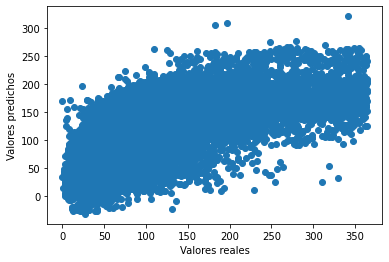

<Figure size 432x288 with 0 Axes>

In [38]:
plt.scatter(y_test, y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.figure()

<Figure size 432x288 with 0 Axes>

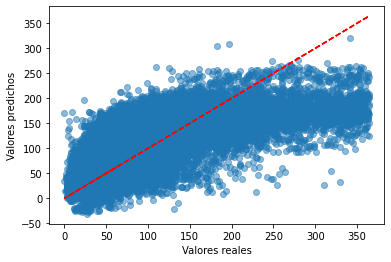

<Figure size 432x288 with 0 Axes>

In [39]:
plt.plot(y_test, y_test, label='Línea de 45 grados', color='r', linestyle='--')
plt.scatter(y_test, y_pred, label='Valores predichos', alpha=0.5)
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.figure()

In [ ]:
##XGBoost

In [142]:
xgb_clf = xgb.XGBRegressor(random_state=123)

In [108]:
df['health_service'] = df['health_service'].astype(int)
df['comorbidity'] = df['comorbidity'].astype(int)

In [143]:
X_train, X_test, y_train, y_test= train_test_split(x, y, test_size=.2, random_state=123)

scaler_x = MinMaxScaler()
x = scaler_x.fit_transform(x)


In [110]:
df.health_service

2         2
3         3
5         4
6         5
7         5
         ..
133847    7
133848    7
133849    3
133850    3
133851    3
Name: health_service, Length: 111943, dtype: int32

In [144]:
## Set max_depth to be 10 instead of 100
xgb_clf.set_params(learning_rate = 0.1, max_depth =  5, 
                   min_child_weight=3, n_estimators= 300)

# Fit it to the training set
xgb_clf.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [145]:
y_pred = xgb_clf.predict(X_test)

<Figure size 432x288 with 0 Axes>

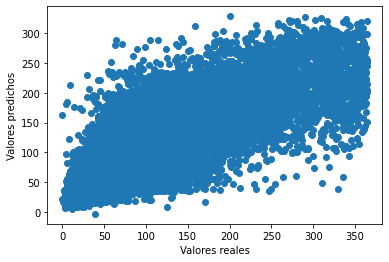

<Figure size 432x288 with 0 Axes>

In [146]:
plt.scatter(y_test, y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Valores predichos")
plt.figure()

[[0.         0.03448276 0.25       ... 0.         0.         0.        ]
 [0.         0.05172414 0.25       ... 0.         0.         0.        ]
 [1.         0.06896552 0.5        ... 0.         0.         0.        ]
 ...
 [1.         0.05172414 0.         ... 0.         0.         0.        ]
 [0.         0.05172414 0.25       ... 0.         0.         0.        ]
 [1.         0.05172414 0.25       ... 0.         0.         0.        ]]
['Feature 15', 'Feature 12', 'Feature 38', 'Feature 11', 'Feature 19', 'Feature 29', 'Feature 43', 'Feature 20', 'Feature 36', 'Feature 31', 'Feature 10', 'Feature 1', 'Feature 9', 'Feature 39', 'Feature 26']


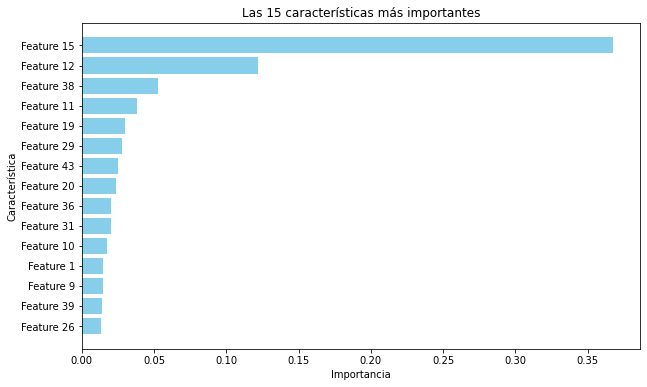

In [157]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Suponiendo que tienes un modelo XGBoost entrenado llamado 'model'
# Y que tienes una lista de nombres de características llamada 'feature_names'

# Obtener las características más importantes y sus índices
importances = xgb_clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Obtener los nombres de las 15 características más importantes
top_15_feature_names = [feature_names[i] for i in indices[:15]]
print(x)
print(top_15_feature_names)

# Obtener las importancias de las 15 características más importantes
top_15_importances = importances[indices[:15]]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(top_15_feature_names, top_15_importances, color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Las 15 características más importantes')
plt.gca().invert_yaxis()  # Invertir el eje y para que las características más importantes estén arriba
plt.show()



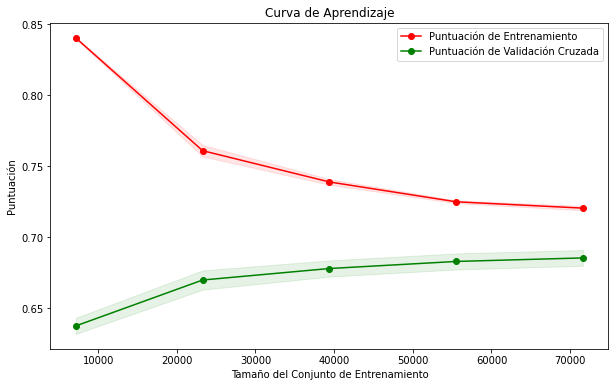

In [159]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Genera una curva de aprendizaje.
    
    Parámetros:
        estimator: Objeto del estimador XGBoost.
        X: Conjunto de características.
        y: Variable objetivo.
        ylim: Tuple, shape (ymin, ymax), valores estáticos para fijar el límite y.
        cv: Objeto de validación cruzada.
        n_jobs: Número de trabajos en paralelo.
        train_sizes: Matriz con los tamaños de entrenamiento especificados.
    """
    plt.figure(figsize=(10, 6))
    plt.title("Curva de Aprendizaje")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Tamaño del Conjunto de Entrenamiento")
    plt.ylabel("Puntuación")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Puntuación de Entrenamiento")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Puntuación de Validación Cruzada")

    plt.legend(loc="best")
    return plt

# Suponiendo que tienes un modelo XGBoost entrenado llamado 'xgb_reg'
# Y que tienes tus datos de entrenamiento 'X_train' y 'y_train'

# Plot learning curve
plot_learning_curve(xgb_clf, X_train, y_train, cv=5, n_jobs=-1)
plt.show()


In [44]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(mse)
print(mae)


1858.8608375134693
28.632774481167747


In [45]:
from joblib import dump, load
dump(xgb_clf, 'mejor_modelo_1.joblib') 


['mejor_modelo_1.joblib']